In [4]:
import sys
sys.path.append('../')

from pathlib import Path

from PIL import Image

import numpy as np

from mosaic.model.dataset import transform
from mosaic.model.dataset import ClusterARTstractDataset
from mosaic.embedding import KGE, VGGImageEncoder, ViTImageEncoder
from mosaic.model.classification import ProjectedSimPrediction

/home/nicolas/.conda/envs/mosaic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = ClusterARTstractDataset(
  Path("/home/nicolas/projects/mosaic/artstract_balanced/test"), 
  Path("/home/nicolas/projects/mosaic/Commonsense_MOSAIC/Common-sense_MOSAIC.ttl"))

In [6]:
kge = KGE("/home/nicolas/projects/mosaic/models/trans_e_128dim.pt",
          "/home/nicolas/projects/mosaic/models/framester_conceptnet_kg.pickle")

In [7]:
image_encoder = VGGImageEncoder()
model = ProjectedSimPrediction.load_from_checkpoint(
  "/home/nicolas/projects/mosaic/output_low_lr/linkprediction_vgg/model.ckpt",
  kge=kge,
  image_encoder=image_encoder,
  num_classes=len(data.targets), 
  cluster_map=data.cluster_concept_map)

/home/nicolas/.conda/envs/mosaic/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nicolas/.conda/envs/mosaic/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
img_idx = 200
sample = data[img_idx]
image, label, label_idx, clusters = sample
label

'https://w3id.org/framester/conceptnet5/data/en/safety'

In [9]:
data.img_path[img_idx]

PosixPath('/home/nicolas/projects/mosaic/artstract_balanced/test/safety/12135.jpg')

In [10]:
def predict_and_explain(sample, k = 5):
  image, label, label_idx, clusters = sample

  # predict
  img_emb = model.image_encoder(image.unsqueeze(0).to(model.device))
  img_emb = model.projection(img_emb)
  pred_probs = torch.nn.functional.softmax(model.classifier(img_emb), dim=-1).reshape(-1).cpu()
  
  preds = dict()
  for p, (label, concepts) in zip(pred_probs, data.cluster_concept_map.items()):
    x = torch.nn.functional.normalize(img_emb)
    W = torch.nn.functional.normalize(model.cluster_map[label])
    sim = (x @ W.T).cpu()
    top_k = sim.argsort(descending=True).reshape(-1)[:k]
    concepts = np.array(data.cluster_concept_map[label])

    preds[label] = {
      "conf": p,
      "concepts": {
        concept: conf
        for concept, conf in zip(concepts[top_k.cpu()], sim.squeeze(0)[top_k].detach())        
      }
    }

  return preds


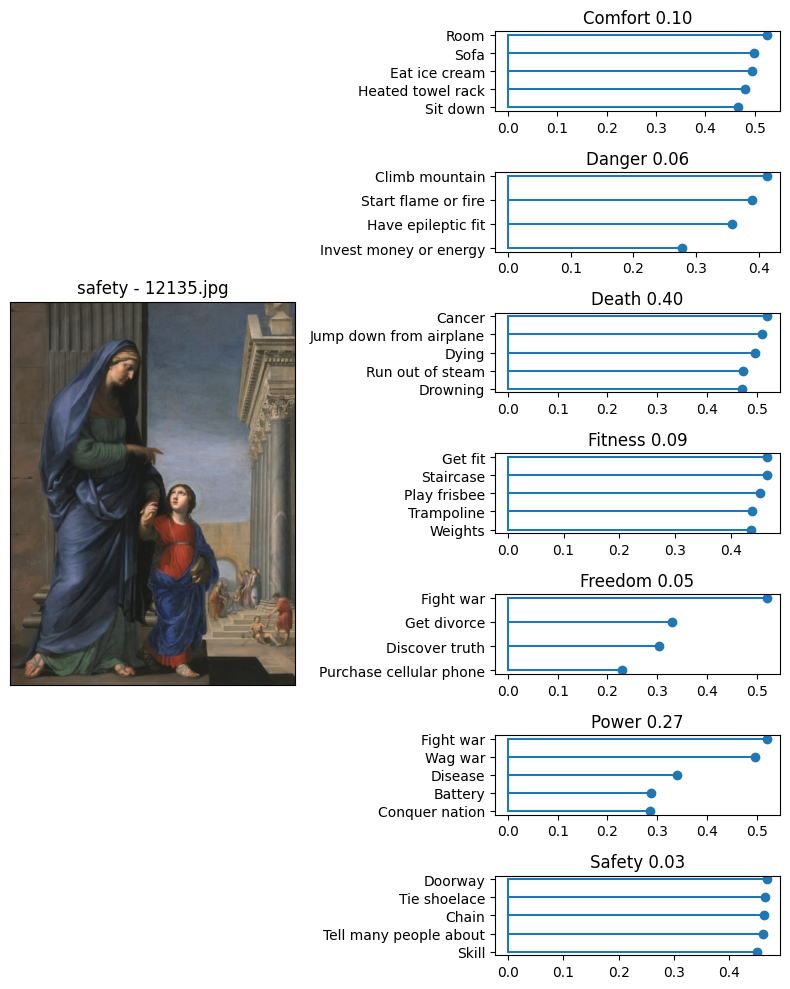

In [65]:
import matplotlib.pyplot as plt
import torch

pred_expl = predict_and_explain(sample)
fig, axs = plt.subplots(len(pred_expl), 2, figsize=(8, 10))

gs = axs[0, 0].get_gridspec()
for ax in axs[:, 0]:
    ax.remove()
img_ax = fig.add_subplot(gs[:, 0])
img_ax.imshow(Image.open(data.img_path[img_idx]))
img_ax.set_title(" - ".join(str(data.img_path[img_idx]).split("/")[-2:]))
img_ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

for idx, (label, content) in enumerate(pred_expl.items()): 
  concept_confs = list(content["concepts"].values())

  axs[idx, 1].stem(concept_confs[::-1], orientation="horizontal", basefmt="")
  axs[idx, 1].set_title(f"{label.split('/')[-1].capitalize()} {content['conf']:0.2f}")

  y_ticks = list(range(len(concept_confs)))
  axs[idx, 1].set_yticks(y_ticks, [c.split("/")[-1].replace("_", " ").capitalize() for c in content["concepts"].keys()][::-1])

fig.tight_layout()